In [1]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as md
import pickle as pkl
import xgboost
import shap
from tensorflow import keras
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler
from itertools import combinations, product
from src.colnames import topic_col, emotion_col, style_col, exclude_col
from utils import _pca_transform, plot_volume

%load_ext autoreload
%autoreload 2

/home/roberta/venvs/tw-langmod/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


AttributeError: module 'lib' has no attribute 'X509_V_FLAG_CB_ISSUER_CHECK'

In [6]:
scipy.__version__

'1.9.1'

### TODO:
- Style over time at month granularity
- Overall discriminability, per year
- Qualitative traits, overall


In [62]:
df = pd.read_json('data/topic/data.jsonl', 
                        orient='records',
                        lines=True)

### Overall number of Tweets

In [63]:
style_short = [c for c in df.columns if 'rauh' in c or 'benoit' in c]

In [64]:
summary = df.groupby('entity').aggregate({'created_at': 'min',
                                          'text': 'count'}).reset_index()
summary['end_date'] = '2022-06-29'
summary[['end_date',
         'created_at']] = summary[['end_date',
                                   'created_at']].apply(pd.to_datetime)
summary['n_days'] = (summary['end_date'] - summary['created_at']).dt.days
summary['tweets_per_day'] = (summary['text'] / summary['n_days']).round(2)
summary.columns = ['entity', 'first tweet', '# tweets', 'last tweet', '# days', 'tweets per day']
summary = summary[['entity', '# tweets', 'first tweet', 'last tweet', '# days', 'tweets per day']]

In [65]:
summary

,entity,# tweets,first tweet,last tweet,# days,tweets per day
0,10DowningStreet,11595,2008-03-26,2022-06-29,5208,2.23
1,EUCouncil,5652,2012-12-04,2022-06-29,3494,1.62
2,EU_Commission,29621,2010-06-23,2022-06-29,4389,6.75
3,Europarl_EN,18485,2009-04-30,2022-06-29,4808,3.84
4,IMFNews,19361,2009-03-24,2022-06-29,4845,4.00
5,OECD,13558,2009-03-19,2022-06-29,4850,2.80
6,UN,42664,2008-12-20,2022-06-29,4939,8.64
7,ecb,14948,2010-04-28,2022-06-29,4445,3.36
8,scotgov,12090,2009-06-16,2022-06-29,4761,2.54


### Plot tweet volume

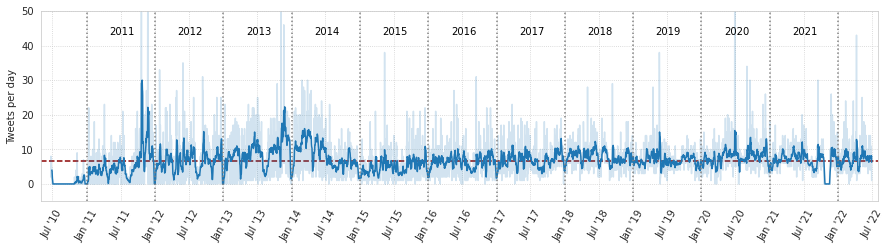

In [66]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plot_volume(df, interactive=False,
            figsize=(15,3.5), 
            plot_smooth_only=False,
            exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission']),
            ylim=True, freq='D', roll_window=7)

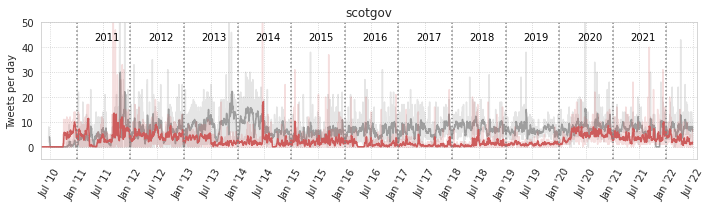

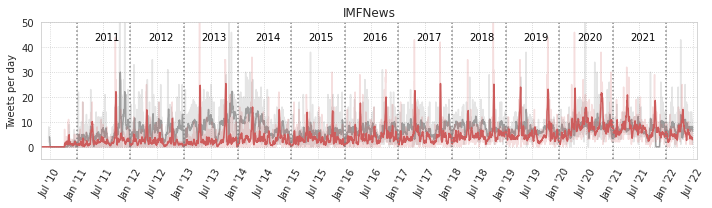

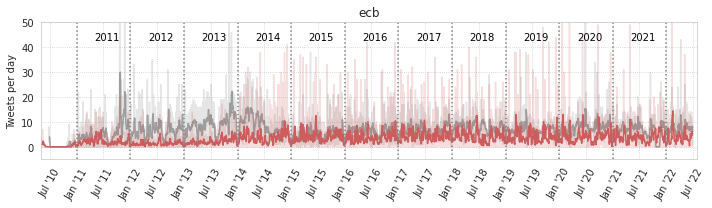

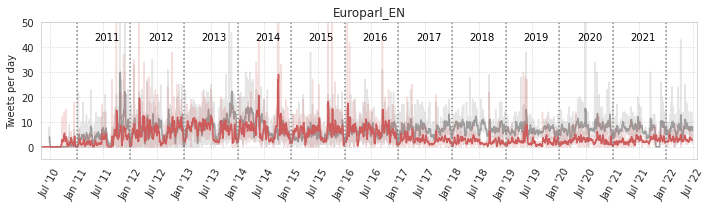

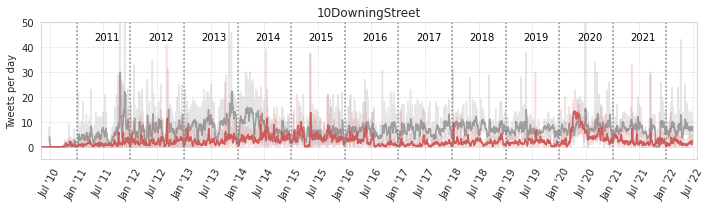

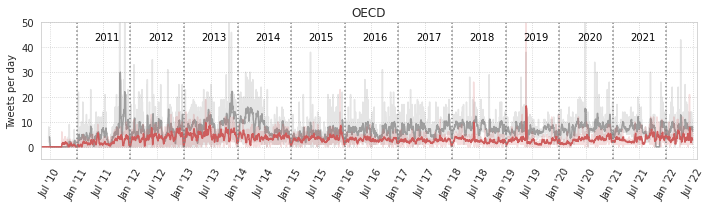

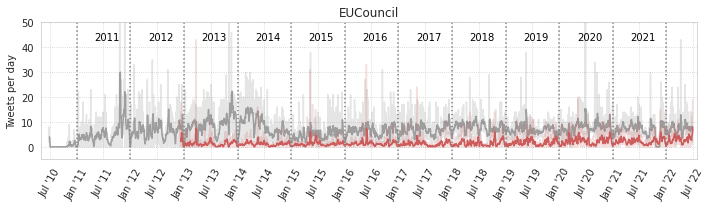

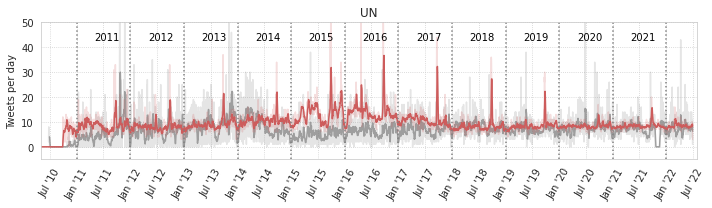

In [171]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
for entity in set(df.entity.unique().tolist()) - set(['EU_Commission']):
    plot_volume(df, interactive=False,
                figsize=(10,3), 
                plot_smooth_only=False,
                exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission', entity]),
                ylim=True, freq='D', roll_window=7,
                multiple=True, colors=['grey', 
                                       'indianred'], 
                savename=entity)

## Style

#### Qualitative style comparison

In [68]:
df['n_mentions'] = df['text'].replace('[^@]','', regex=True).str.len()
df['n_hashtag'] = df['text'].replace('[^#]','', regex=True).str.len()
for c in ['n_hashtag', 'n_mentions', 'n_emojis']:
    df[c] = df[c] / df['benoit_sentence-length-words']

#### Style over time

In [71]:
df['year'] = df['created_at'].apply(lambda x: x.year)
df['month'] = df['created_at'].apply(lambda x: x.month)

In [94]:
style_targets = [c for c in df.columns if any(['rauh' in c, 
                                               'benoit' in c, 
                                               'alpha_ratio' in c])] + \
                ['n_hashtag', 'n_mentions', 'is_link', 'n_emojis']
sentiment_targets = [c for c in df.columns if 'sentiment' in c]
categories = ['multimodal', 'word complexity', 'action', 'readability',
              'readability', 'sentence complexity', 'sentence complexity',
              'sentence complexity', 'word complexity', 'word complexity',
              'action', 'multimodal', 'multimodal', 'multimodal', 'multimodal',
              'sentiment', 'sentiment', 'sentiment']
mapdict = dict(zip(style_targets+sentiment_targets, categories))

In [194]:
new_names = ['% alphanumeric', 
             'frequency',
            'verb-to-noun ratio', 
             'Flesch-Kincaid Grade',
             'Flesch reading ease',
             '# words', 
             'sentence length (words)', 
             'sentence length (chars)', 
             'word length (syllables)',
             'word length (chars)', 
             '% nouns', 
             '% hashtag', '% mentions', 
             'has link', '% emojis',
             'negative sentiment', 'neutral sentiment', 'positive sentiment']

In [195]:
param_categories = ['alpha', 'sentence complexity', 'action', 
                    'readability', 'sentence complexity', 
                    'sentence complexity', 'word complexity', 
                    'word complexity', 
                    'alpha', 'alpha', 'alpha', 'alpha', 
                    'sentiment', 'sentiment', 'sentiment', 
                    'word complexity', 'readability', 'action']
sort_entities = ['10DowningStreet', 'scotgov', 
                 'UN', 'Europarl_EN', 'EUCouncil', 
                 'ecb', 'IMFNews', 'OECD']

### Within EU Commission, over time

In [238]:
df_standard = df.copy()
for c in style_targets + sentiment_targets:
    df_standard[c] = (df_standard[c] - df_standard[c].mean()) / df_standard[c].std()
grouped = df_standard[df_standard['entity']=='EU_Commission'].groupby('year')[style_targets + sentiment_targets].agg(np.nanmean).reset_index()

In [239]:
grouped_long = grouped.melt(id_vars='year')

In [240]:
grouped_long['category'] = grouped_long['variable'].map(mapdict)
grouped_long['variable'] = grouped_long['variable'].map(dict(zip(style_targets+sentiment_targets,
                                                                 new_names)))
grouped = grouped.rename(dict(zip(style_targets+sentiment_targets, new_names)),
                         axis=1)

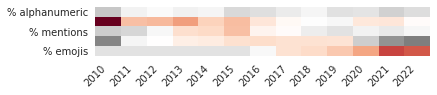

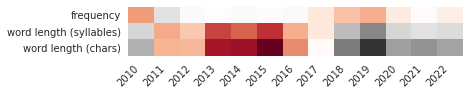

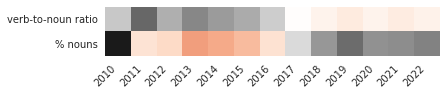

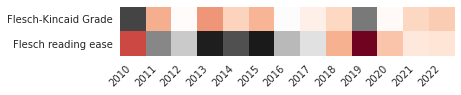

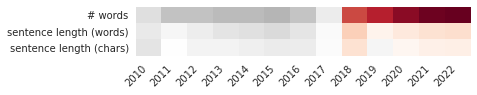

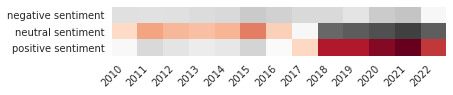

In [241]:
from sklearn.preprocessing import MinMaxScaler

for c in grouped_long.category.unique():
    sub_grouped = grouped[grouped_long[grouped_long['category']==c].variable.unique().tolist()]
    #cols = sub_grouped.columns
    #sub_grouped = MinMaxScaler().fit_transform(sub_grouped)
    #sub_grouped = pd.DataFrame(sub_grouped, columns=cols)
    plt.subplots(figsize=(6,0.3*len(cols)))
    sns.heatmap(sub_grouped.T, cmap='RdGy_r', center=.0, cbar=False)
    plt.xticks(ticks=range(grouped.year.nunique()),
               labels=grouped.year.unique(),
               rotation=45)
    plt.show()

#### Similarity with different institutions, over time

In [242]:
targs = style_targets + sentiment_targets
sub = df_standard.groupby(['year', 'month', 'entity'])[targs].mean().reset_index()


import itertools
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

entities = list(itertools.combinations(df.entity.unique(), 2))
cors = []
for year in df.year.unique():
    for e0, e1 in entities:
        if e0 == 'EU_Commission' or e1 == 'EU_Commission':
            s1 = sub[(sub['year']==year) & (sub['entity']==e0)][targs].values
            s2 = sub[(sub['year']==year) & (sub['entity']==e1)][targs].values
            if len(s1) > 0 and len(s2) > 0:
                c = cosine_similarity(s1, s2)[0][0]
                if e0 == 'EU_Commission':
                    cors.append((year, e1, c))  
                else:
                    cors.append((year, e0, c))
cor_df = pd.DataFrame(cors, columns=['year', 'entity', 'cor'])
cor_df['date'] = pd.to_datetime(cor_df[['year']].assign(day=1, month=1)).dt.strftime('%b \'%y') 

vals = pd.to_datetime(cor_df[['year']].assign(day=1, month=1)).sort_values().dt.strftime('%b \'%y').unique() # , 'month'
dct = dict(zip(vals, range(vals.shape[0])))

cor_df['date_mapped'] = cor_df['date'].replace(dct)
inv_dct = dict(zip(dct.values(), dct.keys()))

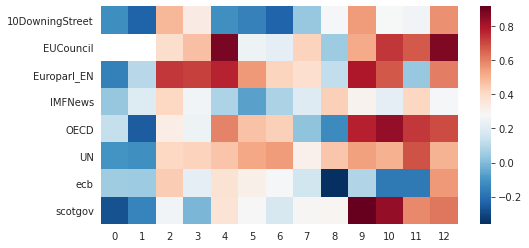

In [243]:
cc = cor_df.pivot(index='entity', columns='date_mapped', values='cor')
# cc = ((cc-cc.mean())/cc.std()).T
#cc = cc[['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
#         '10DowningStreet', 'IMFNews', 'ecb'][::-1]]
# cc = cc.T

plt.subplots(figsize=(8,4))
ax = sns.heatmap(cc, 
            cmap='RdBu_r')
plt.xlabel('')
plt.ylabel('')
#plt.xticks(ticks=np.arange(3,143,12),
#           labels=[f'20{inv_dct[k][5:]}' for k in np.arange(3,143,12)],
#           rotation=45)
plt.show()
# , 'month'

In [ ]:
# Overall similarity over time (Euclidean distance with other agencies)
# Overall discriminability (at three time steps)

#### Qualitative plot: overall similarity, per trait

In [12]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

ests = []
for t in style_targets + sentiment_targets:
    scaler = StandardScaler()
    new_t_name = t.replace('-','_')
    data = df.rename({t: new_t_name}, axis=1).fillna(0)
    data[new_t_name] = scaler.fit_transform(data[[new_t_name]])
    formula = f"{new_t_name} ~ C(entity, Treatment(reference='EU_Commission'))"
    
    # Specify model
    mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT())
    
    # Freq workflow
    res = mod.fit()
    # print(f'\n{t}\n')
    # print(res.summary())
    
    # Save estimates
    est_df = pd.DataFrame(res.params, columns=['param'])
    est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", 
                                                   regex=True)
    est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
    est_df['target'] = t
    est_df['p_val'] = res.pvalues.values
    est_df = est_df[~est_df['predictor'].isin(topic_col)]
    est_df = est_df.reset_index(drop=True)
    est_df = est_df[est_df['predictor']!='Intercept']
    ests.append(est_df)
    
# Make joint dataset
ests = pd.concat(ests)
conditions = [
    (ests["p_val"].lt(0.001)),
    (ests["p_val"].ge(0.001) & ests["p_val"].lt(0.01)),
    (ests["p_val"].ge(0.01) & ests["p_val"].lt(0.05)),
    (ests["p_val"].ge(0.05)),
]

choices = ["", "", "", 'ns']
ests["p_val"] = np.select(conditions, choices)
ests['param_str'] =  '$' + ests['param'].round(2).astype(str) + '^{' + ests['p_val'] + '}$'

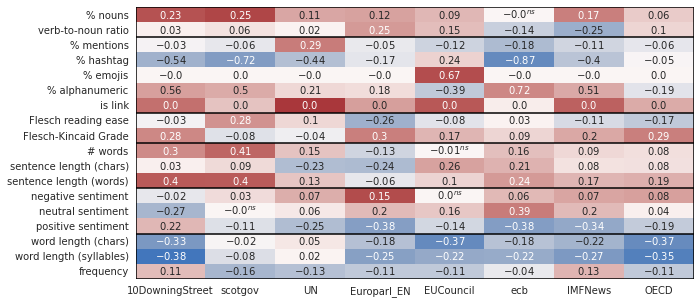

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

wide_params = ests.pivot("target", "predictor", "param")
wide_params = wide_params[sort_entities]
wide_params['category'] = param_categories
wide_params = wide_params.reset_index().sort_values(by='category').set_index('target')
wide_params.index = ['% nouns', 'verb-to-noun ratio',
                     '% mentions', '% hashtag',
                     '% emojis', '% alphanumeric', 'is link', 
                     'Flesch reading ease', 'Flesch-Kincaid Grade',
                     '# words',
                     'sentence length (chars)', 'sentence length (words)', 
                     'negative sentiment', 'neutral sentiment', 'positive sentiment',
                     'word length (chars)', 'word length (syllables)',
                     'frequency']
wide_params.index = pd.CategoricalIndex(wide_params.index)

annot = ests.pivot("target", "predictor", "param_str")
annot = annot[sort_entities]
annot.index = wide_params.index
annot['category'] = param_categories
annot = annot.reset_index().sort_values(by='category').set_index('index')
annot.index = pd.CategoricalIndex(annot.index)

data = wide_params.drop('category', axis=1)
sns.heatmap((data/np.vstack([data.std(axis=1).values]*8).T).values,
             cbar=False, cmap='vlag', 
             annot=annot.drop('category', axis=1),
             fmt = '', center=0)
plt.xticks(ticks=np.array(range(len(data.columns)))+.5, 
           labels=data.columns)
plt.yticks(ticks=np.array(range(len(data.index)))+.5,
           labels=data.index, rotation=0)
for i in [0,2,7,9,12,15,18]:
    plt.axhline(i, color='black')
plt.axvline(0, color='black')
plt.axvline(8, color='black')
plt.xlabel('')
plt.show()

catmap = dict(zip(wide_params.index.tolist(), wide_params['category']))

Same, with topics as controls

In [56]:
ests = []
for t in style_targets + sentiment_targets:
    scaler = StandardScaler()
    new_t_name = t.replace('-','_')
    data = df.rename({t: new_t_name}, axis=1).fillna(0)
    data[new_t_name] = scaler.fit_transform(data[[new_t_name]])
    formula = f"{new_t_name} ~ C(entity, Treatment(reference='EU_Commission')) + {' + '.join(topic_col)}" # added topics for control
    
    # Specify model
    mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT())
    
    # Freq workflow
    res = mod.fit()
    # print(f'\n{t}\n')
    # print(res.summary())
    
    # Save estimates
    est_df = pd.DataFrame(res.params, columns=['param'])
    est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", 
                                                   regex=True)
    est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
    est_df['target'] = t
    est_df['p_val'] = res.pvalues.values
    est_df = est_df[~est_df['predictor'].isin(topic_col)]
    est_df = est_df.reset_index(drop=True)
    est_df = est_df[est_df['predictor']!='Intercept']
    ests.append(est_df)
    
# Make joint dataset
ests = pd.concat(ests)
conditions = [
    (ests["p_val"].lt(0.001)),
    (ests["p_val"].ge(0.001) & ests["p_val"].lt(0.01)),
    (ests["p_val"].ge(0.01) & ests["p_val"].lt(0.05)),
    (ests["p_val"].ge(0.05)),
]

choices = ["", "", "", 'ns']
ests["p_val"] = np.select(conditions, choices)
ests['param_str'] =  '$' + ests['param'].round(2).astype(str) + '^{' + ests['p_val'] + '}$'

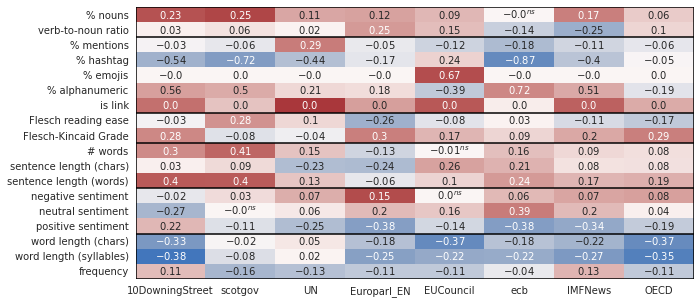

In [57]:
fig, ax = plt.subplots(figsize=(10,5))

wide_params = ests.pivot("target", "predictor", "param")
wide_params = wide_params[sort_entities]
wide_params['category'] = param_categories
wide_params = wide_params.reset_index().sort_values(by='category').set_index('target')
wide_params.index = ['% nouns', 'verb-to-noun ratio',
                     '% mentions', '% hashtag',
                     '% emojis', '% alphanumeric', 'is link', 
                     'Flesch reading ease', 'Flesch-Kincaid Grade',
                     '# words',
                     'sentence length (chars)', 'sentence length (words)', 
                     'negative sentiment', 'neutral sentiment', 'positive sentiment',
                     'word length (chars)', 'word length (syllables)',
                     'frequency']
wide_params.index = pd.CategoricalIndex(wide_params.index)

annot = ests.pivot("target", "predictor", "param_str")
annot = annot[sort_entities]
annot.index = wide_params.index
annot['category'] = param_categories
annot = annot.reset_index().sort_values(by='category').set_index('index')
annot.index = pd.CategoricalIndex(annot.index)

data = wide_params.drop('category', axis=1)
sns.heatmap((data/np.vstack([data.std(axis=1).values]*8).T).values,
             cbar=False, cmap='vlag', 
             annot=annot.drop('category', axis=1),
             fmt = '', center=0)
plt.xticks(ticks=np.array(range(len(data.columns)))+.5, 
           labels=data.columns)
plt.yticks(ticks=np.array(range(len(data.index)))+.5,
           labels=data.index, rotation=0)
for i in [0,2,7,9,12,15,18]:
    plt.axhline(i, color='black')
plt.axvline(0, color='black')
plt.axvline(8, color='black')
plt.xlabel('')
plt.show()

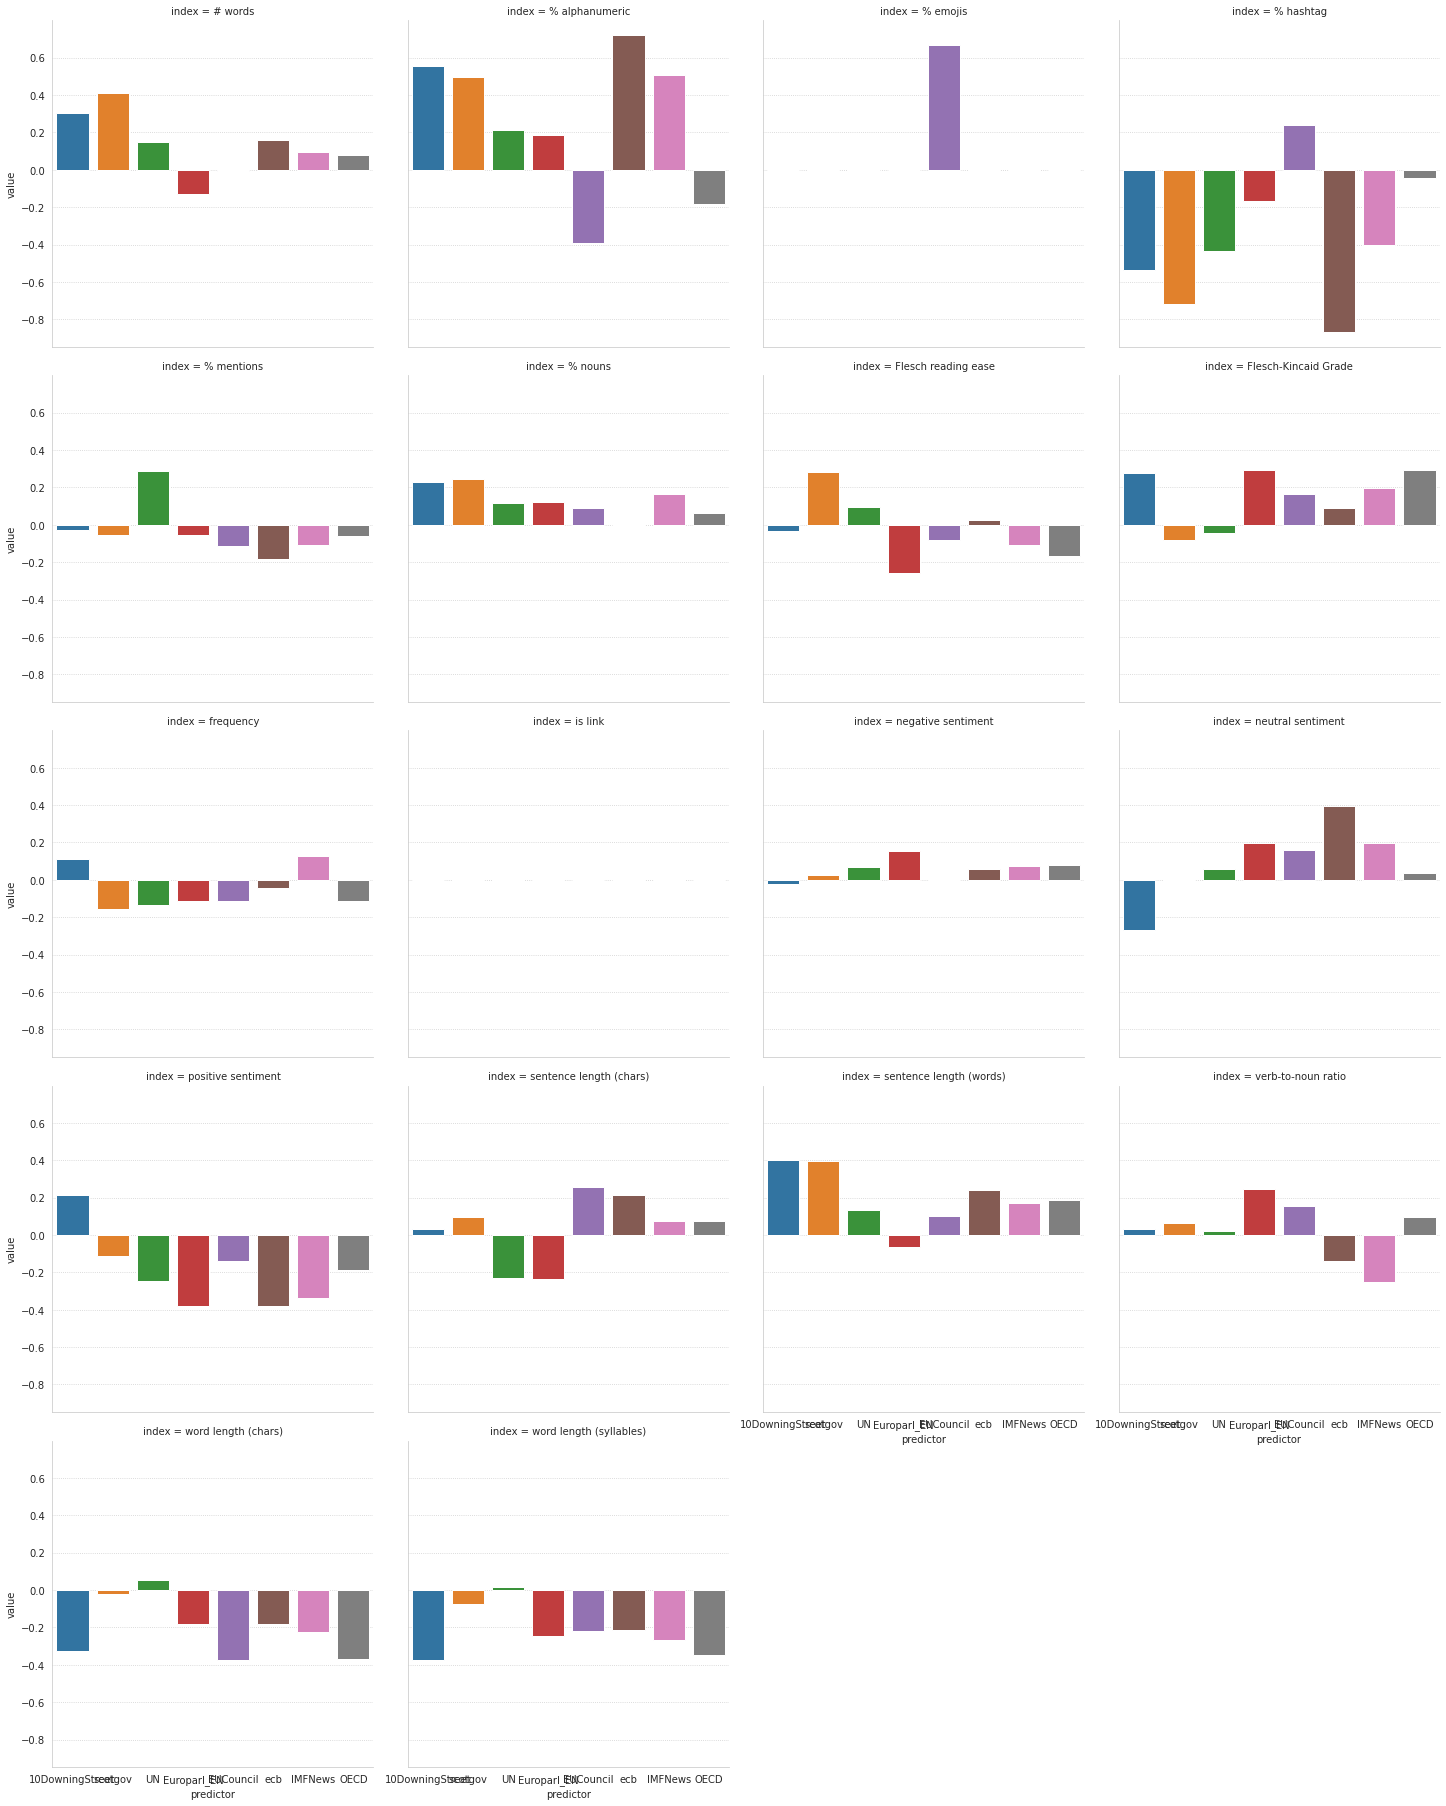

In [59]:
long_params = wide_params.reset_index().melt(id_vars=['index', 'category'])
sns.catplot(data=long_params, x='predictor', y='value', col='index', col_wrap=4,
            kind='bar')

#### Quantitative style comparison

In [16]:
edict = dict(zip(list(wide_params.columns[:-1]) + ['EU_Commission'], 
                 range(len(wide_params.columns[:-1]) + 1)))

In [17]:
all_data = pd.read_json('data/topic/data.jsonl', 
                        orient='records',
                        lines=True)
all_data['n_mentions'] = all_data['text'].replace('[^@]','', regex=True).str.len()
all_data['n_hashtag'] = all_data['text'].replace('[^#]','', regex=True).str.len()
for c in ['n_hashtag', 'n_mentions', 'n_emojis']:
    all_data[c] = all_data[c] / all_data['benoit_sentence-length-words']

In [18]:
bow_targets = [c for c in all_data.columns if 'bow_500' in c]

alpha_targets = ['is_link',
                 'n_hashtag',
                 'n_mentions',
                 'n_emojis']

action_targets = ['rauh_verb-to-noun', 
                  'benoit_prop-noun']

sentence_targets = ['benoit_overall-length', 
                    'benoit_sentence-length-words',
                    'benoit_sentence-length-characters']

word_targets = ['rauh_frequency',
                'benoit_word-length-syllables',
                'benoit_word-length-characters']

readability_targets = ['rauh_readability', 'benoit_readability']

feature_set_names = ['style', 'bow', 'all',
                     'sentiment', 'alpha',
                     'action', 'sentence complexity',
                     'word complexity', 'readability',
                     'topic', 'topic and style']

feature_sets = [style_targets, 
                bow_targets, 
                style_targets + bow_targets,
                sentiment_targets, 
                alpha_targets, 
                action_targets,
                sentence_targets, 
                word_targets, 
                readability_targets,
                topic_col,
                topic_col + style_targets]

Testing as performance of binary classifiers

In [66]:
perfs = []
for i in range(5):
    print(f'Run {i}')
    
    for feature, name in zip(feature_sets[-2:], feature_set_names[-2:]):
        for e in wide_params.columns[:-1]:

            scaler = StandardScaler()

            # Make datasets
            trains = []; vals = [];
            for en in [e, 'EU_Commission']:
                trains.append(all_data[all_data['entity']==en].sample(1000, replace=True))
                vals.append(all_data[all_data['entity']==en].sample(1000, replace=True))
            trains = pd.concat(trains).sample(frac=1)
            train_X = scaler.fit_transform(trains[feature].fillna(0).values)
            train_y = trains['entity'].map({e: 1.0, 'EU_Commission': 0.0})
            vals = pd.concat(vals).sample(frac=1)
            val_X = scaler.fit_transform(vals[feature].fillna(0).values)
            val_y = vals['entity'].map({e: 1.0, 'EU_Commission': 0.0})

            # Define model
            inputs = keras.Input(shape=(len(feature)))
            x = keras.layers.Dense(units=len(feature))(inputs)
            x = keras.layers.Dense(units=len(feature))(x)
            outputs = keras.layers.Dense(1, activation='sigmoid')(x)
            model = keras.Model(inputs, outputs)
            model.compile(optimizer='rmsprop', 
                          loss=keras.losses.BinaryCrossentropy(from_logits=False),
                          metrics='accuracy')

            # Fit and evaluate
            model.fit(train_X, train_y, epochs=100, 
                      verbose=0,
                      validation_split=.2, 
                      callbacks=keras.callbacks.EarlyStopping(patience=3))

            # Plot
            perfs.append((name, e, round(model.evaluate(val_X, val_y, verbose=0)[1],3)))
perf_df = pd.DataFrame(perfs, columns=['name', 'entity', 'score'])
# perf_df.to_json('logs/classifiers.jsonl', orient='records', lines=True)

Run 0
Run 1
Run 2
Run 3
Run 4


In [71]:
perf_df = pd.read_json('logs/classifiers.jsonl', orient='records', lines=True)

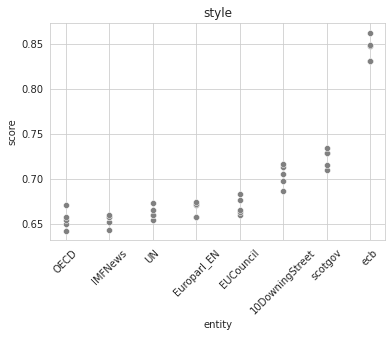

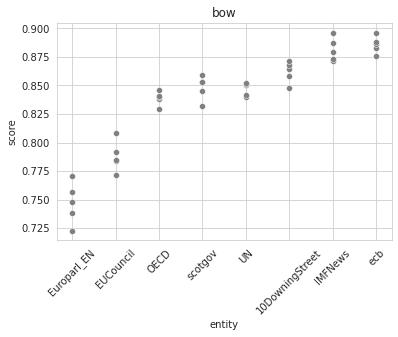

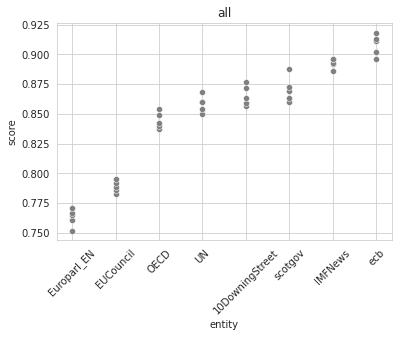

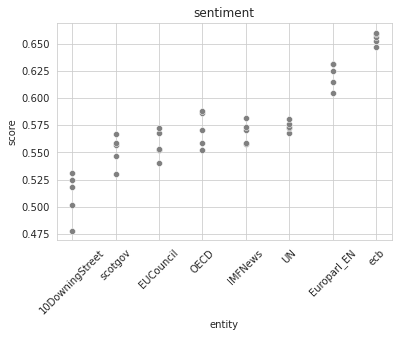

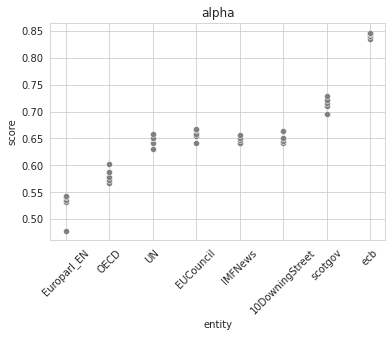

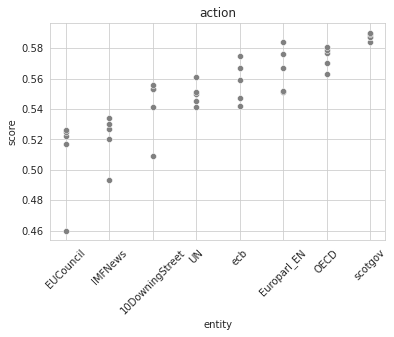

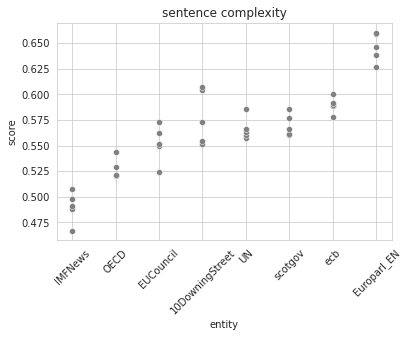

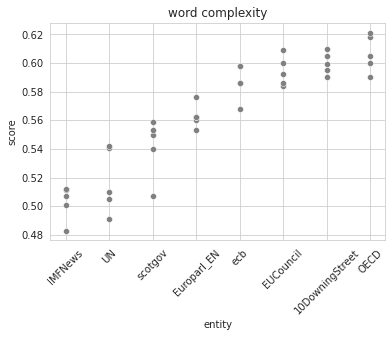

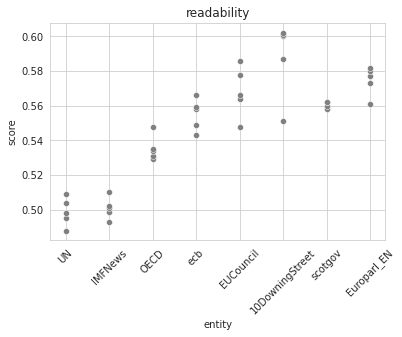

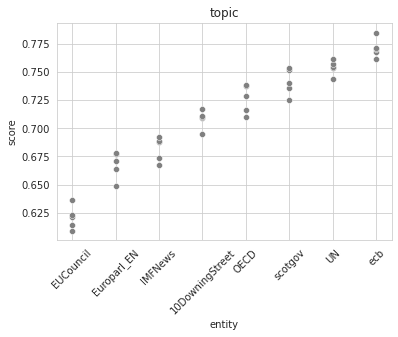

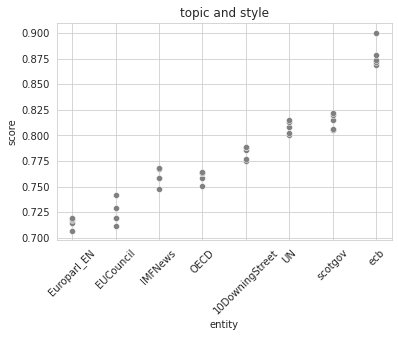

In [72]:
for n in perf_df['name'].unique():
    sns.set_style('whitegrid')
    sns.scatterplot(data=perf_df[perf_df['name']==n].sort_values(by=['score']), 
                  x='entity', y='score', color='grey')
    plt.xticks(rotation=45)
    plt.title(n)
    plt.show()


### Transformer-based discriminability
For comparison

In [24]:
d = pd.DataFrame(json.load(open('logs/classifier/performances.json')))

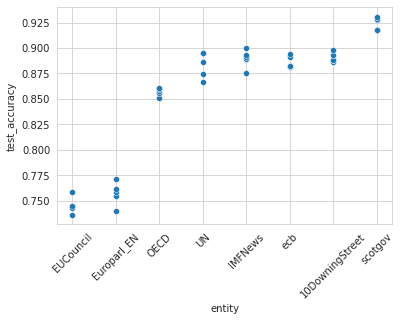

In [25]:
sns.scatterplot(data=d.sort_values(by='test_accuracy'), x='entity', y='test_accuracy')
plt.xticks(rotation=45)
plt.show()

### Results of predictive models

#### Inspect transformers models

In [84]:
d = json.load(open('logs/transformers/sum_count.json'))
d += json.load(open('logs/engagement/sum_count.json'))

In [85]:
tr_res = pd.DataFrame(d).sort_values(by='test_r2')
tr_res['model'] = tr_res['model'].str.replace('sum_count_', '')

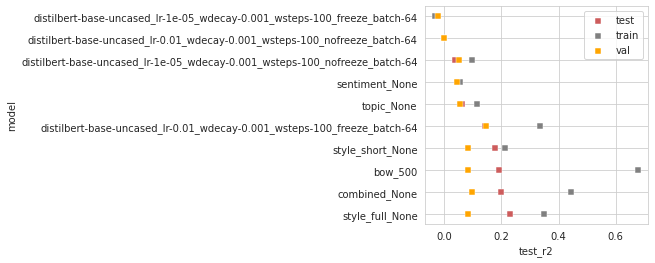

In [86]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=tr_res, x='test_r2', y='model', label='test', color='indianred', marker='s')
sns.scatterplot(data=tr_res, x='train_r2', y='model', label='train', color='grey', marker='s')
sns.scatterplot(data=tr_res, x='val_r2', y='model', label='val', color='orange', marker='s')
plt.show()

In [87]:
dfs = []
for metric in ['sum']:
    fs = glob.glob(f'logs/*/{metric}_count/pred*.pkl')
    for f in fs:
        f_df = pd.read_pickle(f)
        f_df['metric'] = metric
        dfs.append(f_df)
    metrics = pd.concat(dfs, ignore_index=True)
    

In [88]:
spears = metrics.groupby(['metric', 'split',
                          'model_name'])[['label', 
                                          'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()
spears = spears.rename({0: 'spearman_cor'}, axis=1)

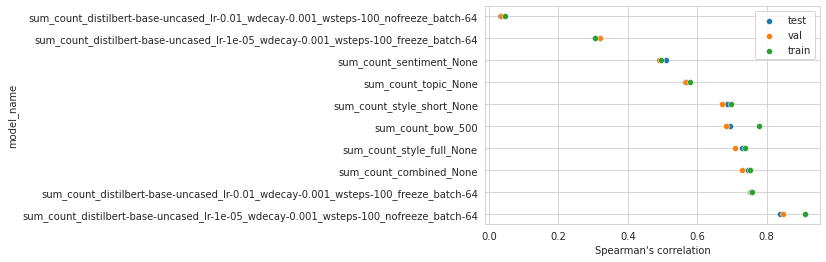

In [89]:
for metric in ['sum']:
    for out_metric in ['spearman_cor']:
        spears = spears.sort_values(by=out_metric, ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=spears[(spears['split']==split) & \
                                        (spears['metric']==metric)],
                            y='model_name', x='spearman_cor', label=split)
        plt.xlabel('Spearman\'s correlation')
        plt.show()

### Predictive models

***** sum *****
logs/engagement/sum_count/sum_count_style_full_None.pkl


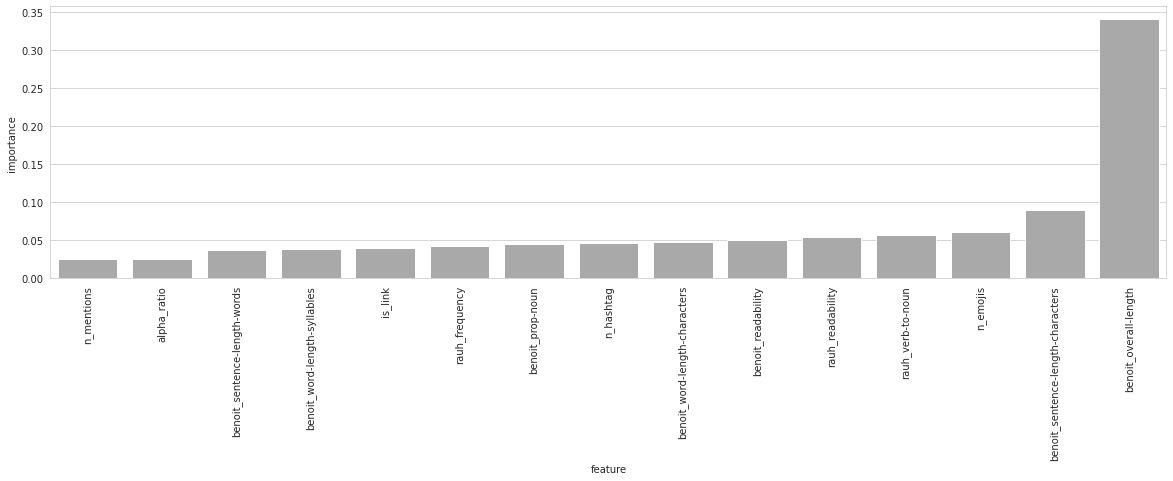

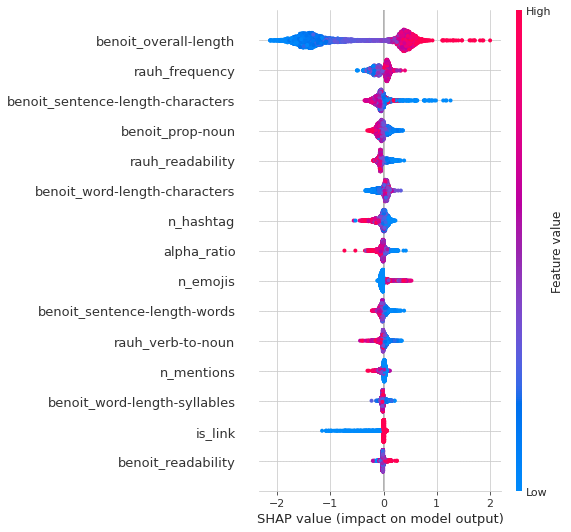

logs/engagement/sum_count/sum_count_combined_None.pkl


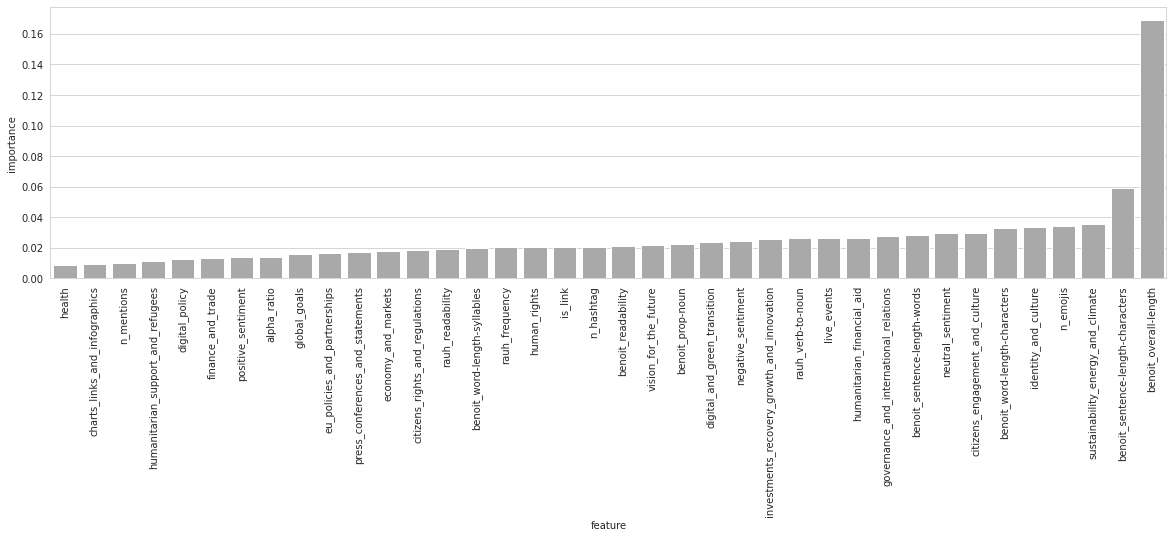

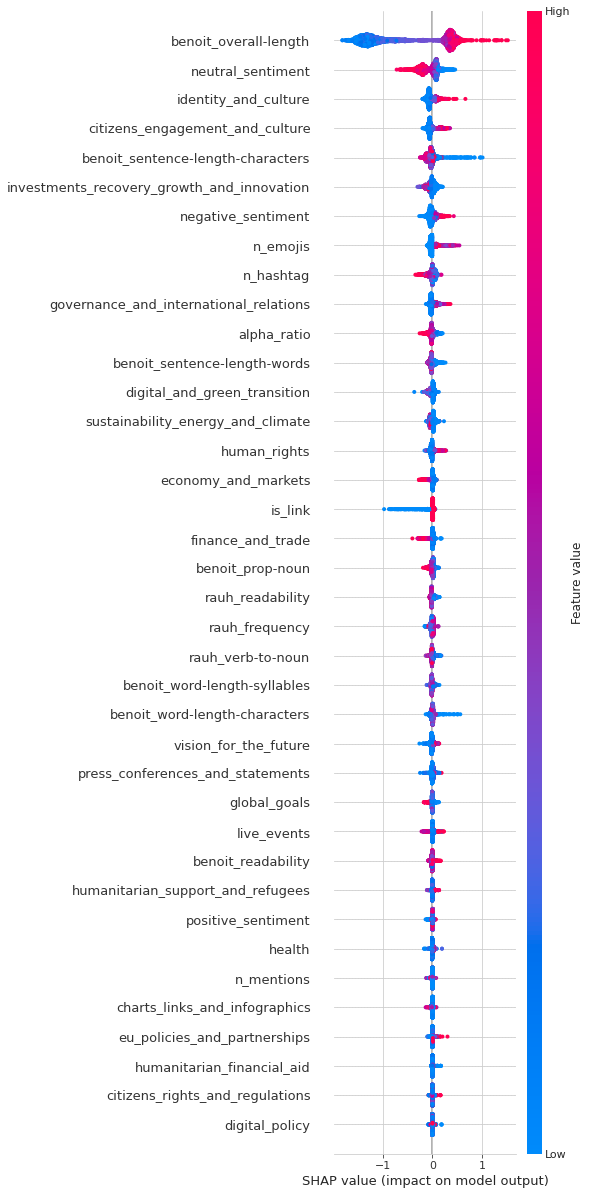

logs/engagement/sum_count/sum_count_style_short_None.pkl


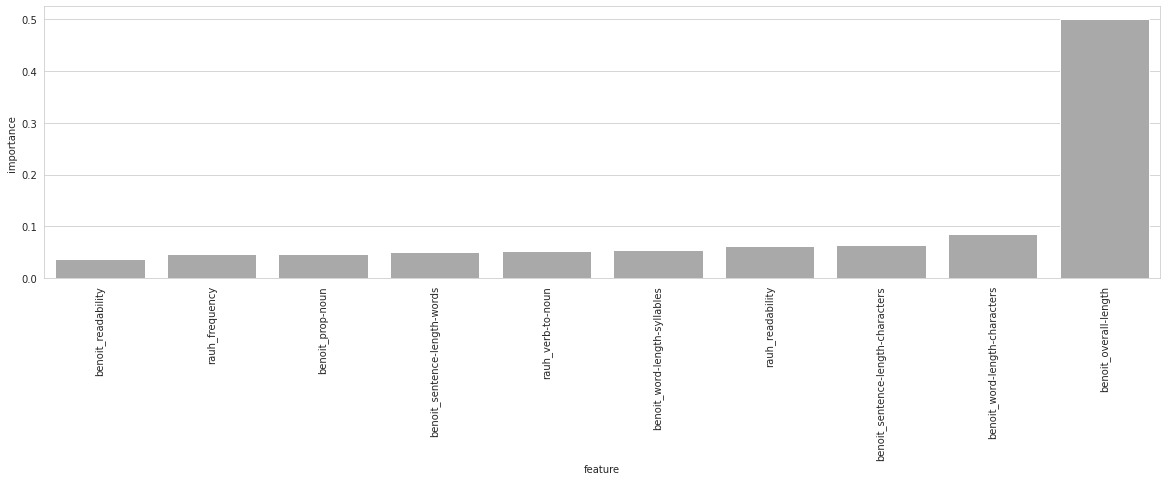

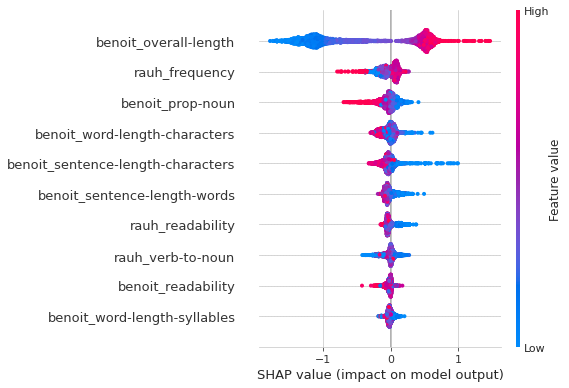

logs/engagement/sum_count/sum_count_sentiment_None.pkl


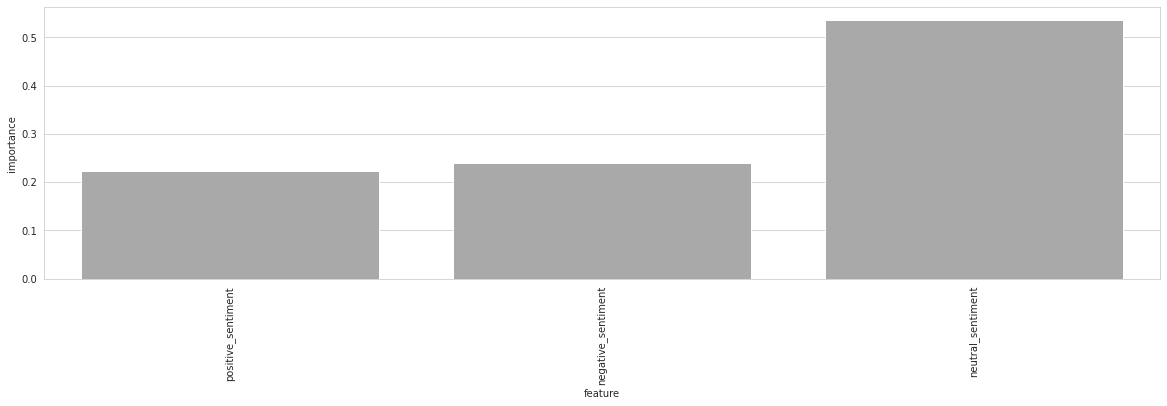

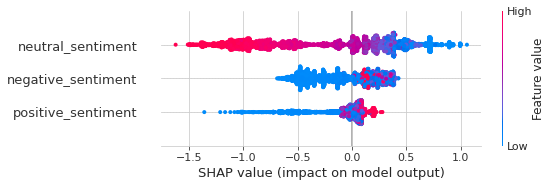

logs/engagement/sum_count/sum_count_bow_500.pkl


/home/roberta/venvs/tw-langmod/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



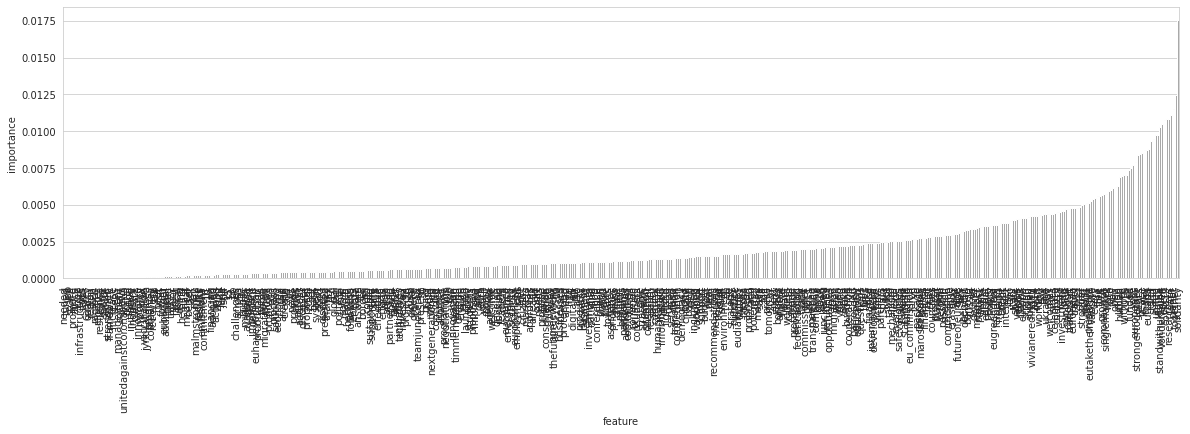

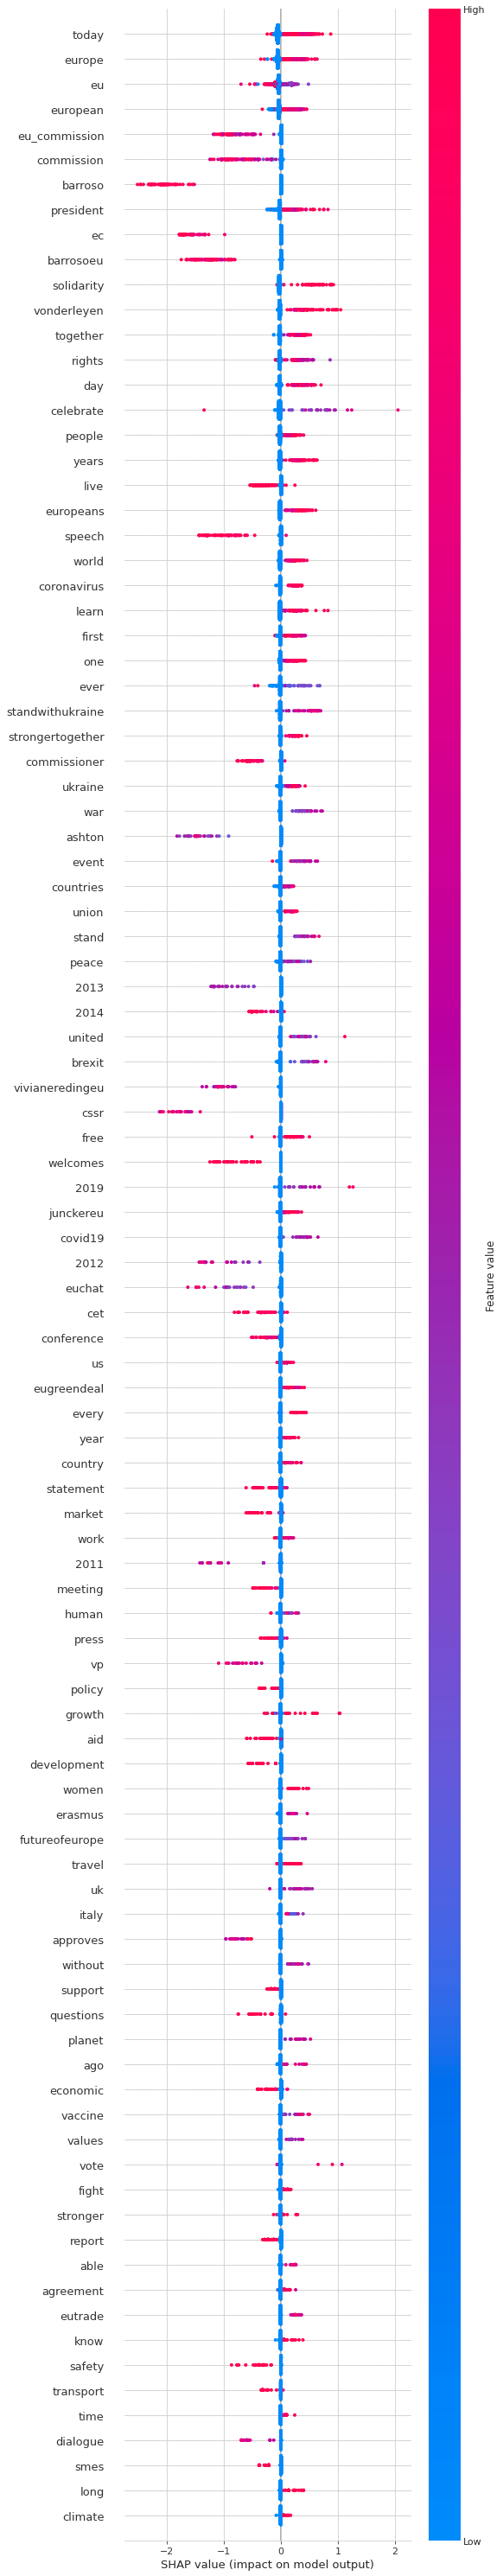

logs/engagement/sum_count/sum_count_topic_None.pkl


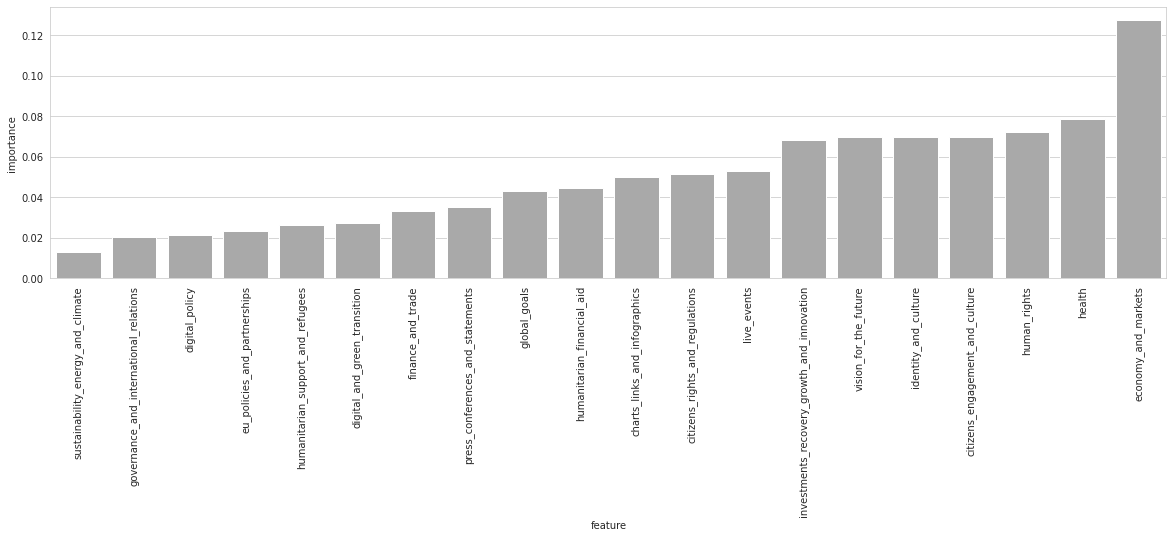

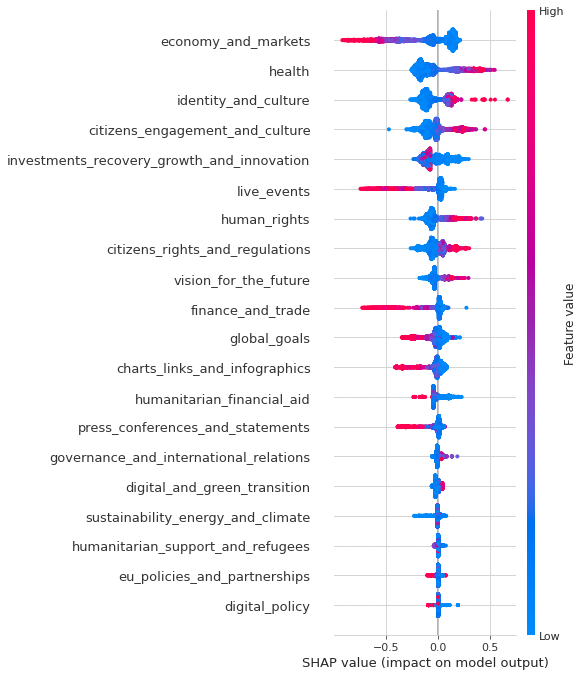

In [90]:
with xgboost.config_context(verbosity=0):
    for metric in ['sum']:
        print(f'***** {metric} *****')
        fnames = glob.glob(f'logs/engagement/{metric}_count/{metric}_count_*.pkl')
        for m in fnames:
            name = m.split('/')[-1]
            model = pkl.load(open(m, 'rb'))
            print(m)
            if 'topic' in m:
                feature_names = topic_col
            elif 'style_short' in m:
                feature_names = style_short
            elif 'style_full' in m:
                feature_names = style_targets
            elif 'combined' in m:
                feature_names = topic_col + emotion_col + style_targets 
            elif 'sentiment' in m:
                feature_names = emotion_col
            else:
                bow_nr = m.split('_')[-1].split('.')[0]
                tokenizer = pkl.load(open(f'logs/engagement/{metric}_count/tokenizer_bow-{bow_nr}.pkl',
                                          'rb'))
                feature_names = tokenizer.get_feature_names()
                
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            plt.subplots(figsize=(20,5))
            sns.barplot(data=df, x='feature', y='importance', color='darkgrey')
            plt.xticks(rotation=90)
            plt.show()
            
            shaps = pkl.load(open(f'logs/engagement/{metric}_count/shap_{name}','rb'))
            if not 'topic' in m:
                df = df.tail(n=50)
                fig, ax = plt.subplots(figsize=(20,4))    
            shap.summary_plot(shaps, max_display=100, feature_names=feature_names)

    

In [164]:
for m in ['sum']:
    d = pd.read_csv(f'logs/engagement/{m}_count/grid.csv').sort_values(by='mean_test_score',
                                                                    ascending=False)